Example from:

https://setigen.readthedocs.io/en/main/getting_started.html

In [6]:
# !pip install astropy>=3.1
!pip3 install pyqt5 # GUI backend for pyplot

ERROR: Invalid requirement: '#'

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import random
import os

from astropy import units as u
import setigen as stg

# fix for non-GUI backend
import matplotlib
matplotlib.use('TkAgg')

from matplotlib import pyplot as plt

import numpy as np
import cv2
import pandas as pd

In [8]:
%matplotlib inline

In [37]:
# Define time and frequency arrays, essentially labels for the 2D data array
fchans = 1714
tchans = 300
df = 10.7939677238464355*u.Hz # how wide the signal band is
dt = 18.253611008*u.s
fch1 = 6095.214842353016*u.MHz

data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'

'''
Generates and saves a positive sample in the same format as the Kaggle SETI samples.
i.e. using the sequence "ABACAD", where "A" are on target images (containing a signal) and the
others are off target images (do not contain signals).
'''
def generate_sample(frequency, drift_rate, drift_step, period, amplitude, gaussian_profile,
                     noise_type, noise_mean, noise_std, noise_min, t_profile, file_name):
    sample_images = []

    for i in range(0, 6):
        frame = stg.Frame(fchans=fchans,
                          tchans=tchans,
                          df=df,
                          dt=dt,
                          fch1=fch1)

        frame.add_noise(x_mean=noise_mean, x_std=noise_std, x_min=noise_min, noise_type=noise_type)

        if (i%2 == 0):
            frame.add_signal(stg.sine_path(f_start=frame.get_frequency(frequency) + i*drift_step,
                                                drift_rate = drift_rate * u.Hz/u.s,
                                                period = period * u.s,
                                                amplitude = amplitude * u.Hz),
                                  stg.constant_t_profile(level=t_profile),
                                  stg.gaussian_f_profile(width=gaussian_profile * u.Hz),
                                  stg.constant_bp_profile(level=1))

        resized_image = cv2.resize(frame.data, dsize=(256, 273), interpolation=cv2.INTER_CUBIC)

        sample_images.append(resized_image) # reread image as a NumPy array

    with open(f'{data_dir}/setigen_data/{file_name}.npy', 'wb') as f:
        np.save(f, sample_images)



for i in range(100):
    file_name = str(i)

    frequency = random.randrange(100, 1400, 10)
    drift_rate = random.randrange(1, 100, 1) / 100
    period = random.sample([1.3, 1.31, 1.32, 1.322, 1.4, 1.41, 1.42], 1)[0]
    amplitude = random.randrange(20, 200, 10)
    gaussian_profile = random.randrange(100, 200, 10)
    noise_type = random.sample(['chi2', 'normal', 'gaussian'], 1)[0]
    noise_mean = random.randrange(50, 100, 10)
    noise_std = random.randrange(50, 100, 10)
    noise_min = random.randrange(50, 100, 10)
    t_profile = random.randrange(10, 100, 10)
    drift_step = random.randrange(20, 100)

    generate_sample(frequency, drift_rate, drift_step, period, amplitude, gaussian_profile,
                     noise_type, noise_mean, noise_std, noise_min, t_profile, file_name)

Read and display one sample for verification

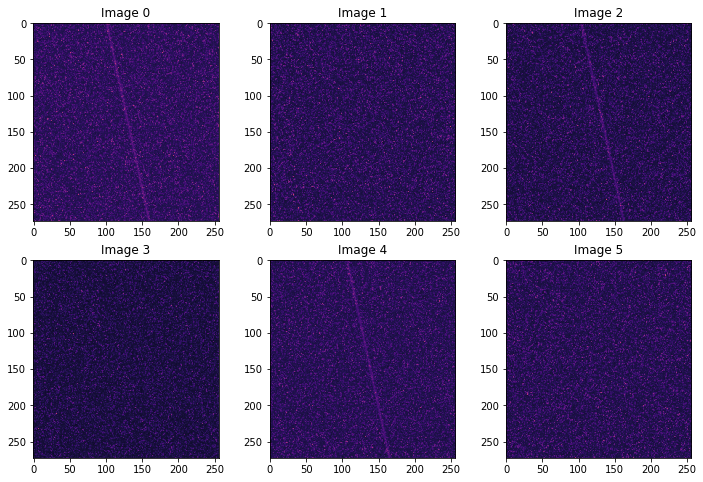

In [39]:
images_filepath = f'{data_dir}/setigen_data/10.npy'

images = np.load(images_filepath).astype(np.float32)

f, ax = plt.subplots(2,3, figsize=(12,8))

# iterate through each image in sample and display it
for i in range(len(images)):
    row = i // 3
    column = i - row * 3

    ax[row, column].set_title('Image ' + str(i))
    ax[row, column].imshow(images[i], cmap=plt.get_cmap('magma'))

## Consolidate with existing SETI dataset

Load existing dataset:

In [41]:
data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_df = pd.read_csv(os.path.join(data_dir, '_labels.csv'), delimiter=',')

# build the path to the labels file
data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_filepath = os.path.join(data_dir, '1000_balanced_labels.npy')

# open as a Numpy pickle file
with open(labels_filepath, 'rb') as f:
    initial_data = np.load(f, allow_pickle=True)

# load into a Pandas dataframe
initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

In [42]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1000 non-null   string
 1   target          1000 non-null   int32 
 2   image_filepath  1000 non-null   string
dtypes: int32(1), string(2)
memory usage: 19.7 KB


Remove 100 positive samples from the dataset, as these will be replaced with the new samples:

In [43]:
initial_data_df[initial_data_df['target'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 500 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              500 non-null    string
 1   target          500 non-null    int32 
 2   image_filepath  500 non-null    string
dtypes: int32(1), string(2)
memory usage: 13.7 KB


Positive samples are from rows 500 onwards, so just drop the last 100:

In [44]:
initial_data_df = initial_data_df.iloc[:-100, :]

initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              900 non-null    string
 1   target          900 non-null    int32 
 2   image_filepath  900 non-null    string
dtypes: int32(1), string(2)
memory usage: 17.7 KB


Add custom data samples to existing ones:

In [45]:
for sample_id in range(100):
    sample_filepath = f'D:\\UoL\\Level 6\\CM3070 - Final Project\\SETI Signal Detection\\Data\\train\\setigen_data\\{sample_id}.npy'
    sample_df = pd.DataFrame({ 'id': [sample_id], 'target': [1], 'image_filepath': [sample_filepath] })

    initial_data_df = pd.concat([initial_data_df, sample_df], ignore_index=True)
    initial_data_df.reset_index()

In [46]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1000 non-null   object
 1   target          1000 non-null   int64 
 2   image_filepath  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [47]:
initial_data_df.tail()

,id,target,image_filepath
995,95,1,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
996,96,1,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
997,97,1,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
998,98,1,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...
999,99,1,D:\UoL\Level 6\CM3070 - Final Project\SETI Sig...


Save new dataframe to disk:

In [48]:
initial_data_df.to_pickle(f'D:\\UoL\\Level 6\\CM3070 - Final Project\\SETI Signal Detection\\Data\\train\\setigen_1000_dataset.pkl')